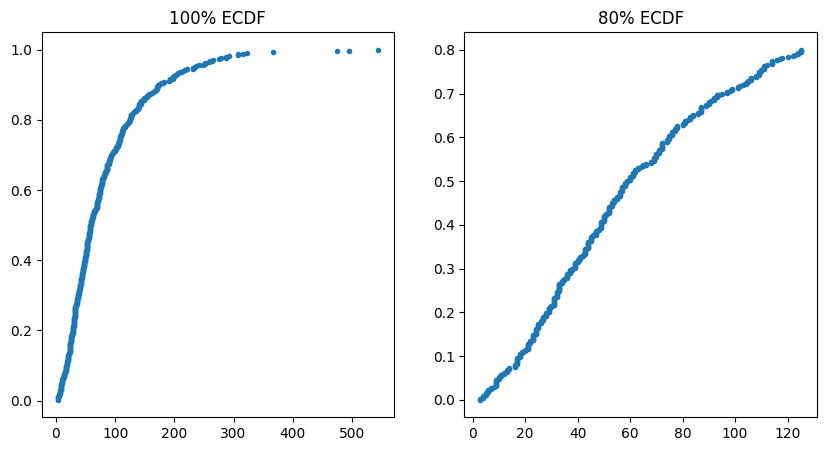

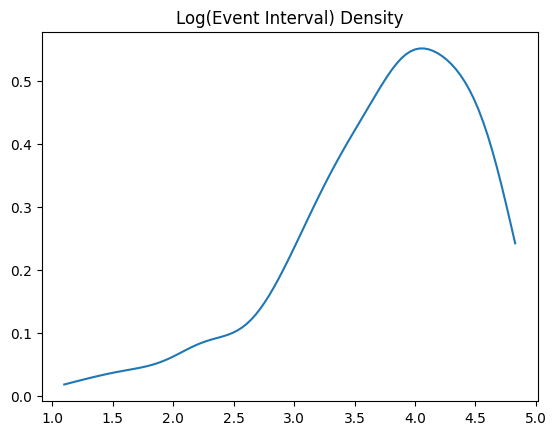

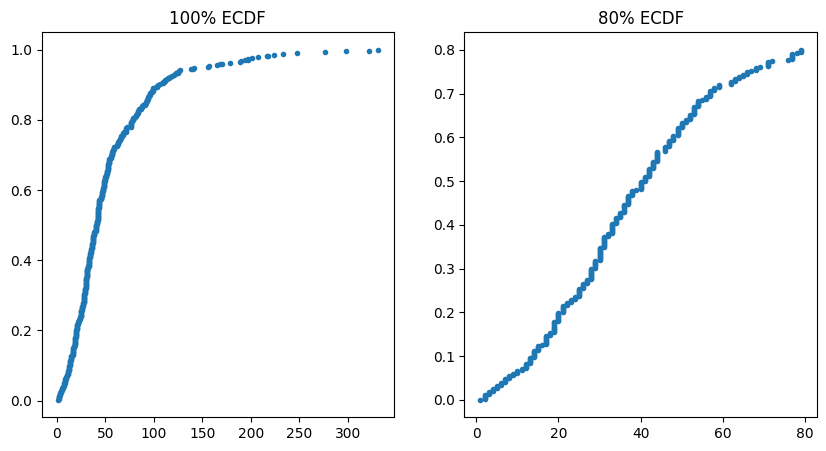

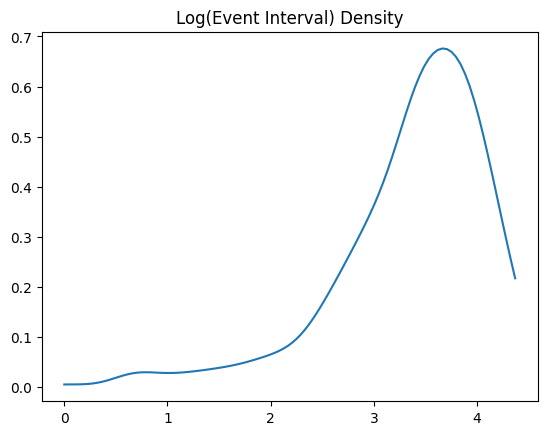

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load dataset
med_events = pd.read_csv("../data/med_events.csv")
med_events.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]
med_events["eksd"] = pd.to_datetime(med_events["eksd"], format="%m/%d/%Y")

def see(arg1):
    drug_data = med_events[med_events["ATC"] == arg1].copy()
    drug_data.sort_values(by=["pnr", "eksd"], inplace=True)
    drug_data["prev_eksd"] = drug_data.groupby("pnr")["eksd"].shift(1)
    drug_data = drug_data.dropna()
    
    # Compute event interval
    drug_data["event_interval"] = (drug_data["eksd"] - drug_data["prev_eksd"]).dt.days
    
    # Ensure event_interval is positive
    drug_data = drug_data[drug_data["event_interval"] > 0]
    if drug_data.empty:
        print("Warning: No valid event intervals greater than zero found.")
        return pd.DataFrame(columns=["pnr", "Median", "Cluster"])
    
    # ECDF Calculation
    ecdf_x = np.sort(drug_data["event_interval"].values)
    ecdf_y = np.arange(1, len(ecdf_x) + 1) / len(ecdf_x)
    
    # Retain 80% ECDF
    threshold = np.percentile(ecdf_x, 80)
    filtered_data = drug_data[drug_data["event_interval"] <= threshold].copy()
    
    # Plot ECDF
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(ecdf_x, ecdf_y, marker=".", linestyle="none")
    plt.title("100% ECDF")
    
    plt.subplot(1, 2, 2)
    plt.plot(filtered_data["event_interval"].sort_values().values, 
             np.linspace(0, 0.8, len(filtered_data)), marker=".", linestyle="none")
    plt.title("80% ECDF")
    plt.show()
    
    # Density plot
    log_intervals = np.log(filtered_data["event_interval"])
    density = gaussian_kde(log_intervals)
    x_vals = np.linspace(min(log_intervals), max(log_intervals), 100)
    
    plt.figure()
    plt.plot(x_vals, density(x_vals))
    plt.title("Log(Event Interval) Density")
    plt.show()
    
    # K-Means Clustering with Silhouette Analysis
    values = log_intervals.values.reshape(-1, 1)
    best_clusters = 2
    best_score = -1
    for k in range(2, 10):
        km = KMeans(n_clusters=k, random_state=1234)
        labels = km.fit_predict(values)
        score = silhouette_score(values, labels)
        if score > best_score:
            best_clusters = k
            best_score = score
    
    # Final K-Means
    km = KMeans(n_clusters=best_clusters, random_state=1234)
    filtered_data.loc[:, "Cluster"] = km.fit_predict(values)
    
    # Assign Median Cluster Values
    cluster_medians = filtered_data.groupby("Cluster")["event_interval"].median().reset_index()
    
    if "Cluster" not in drug_data.columns:
        drug_data["Cluster"] = np.nan  # Ensure Cluster column exists
    
    drug_data = drug_data.merge(cluster_medians.rename(columns={"event_interval": "Median"}), on="Cluster", how="left")
    
    return drug_data[["pnr", "Median", "Cluster"]]

# Example Calls
medA = see("medA")
medB = see("medB")
